In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

LOAD CELL MEASUREMENTS

In [306]:
#We load the measurements:

#measurement_data= np.loadtxt('MCV.210604.OF2..Red Sweep Opening.txt', skiprows=1)
measurement_data= np.loadtxt('MCV.210602.OT2m2.recalibrated..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210921.0830ThY62.ForEQEmeasurement..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210803.0712OT2.1SUN210712..Red Sweep Opening.txt', skiprows=1)

measure_Jsc = -0.1*measurement_data[:,2]

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]



measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
#min_cutwl = 410
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)
print(min_cutwl, max_cutwl)



350.0 750.0


LOAD SPECTRA DATA AND COMPUTE C MATRIX

In [380]:
txt_filelist = os.listdir(os.path.join(os.getcwd(),'Red Sweep Opening'))
int_time = 0.0001*1.25
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data = None
bg_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[0]), skiprows=1)

for i in range(len(txt_filelist)-1):
    load_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

cut_wl_relation = np.loadtxt(os.path.join('Red Sweep Opening','Red Sweep Opneing - cutting wavelenght relation.txt'), skiprows=1)#Dividing Wavelength To Motor Position Calibration File.txt

(0.0, 2.0)

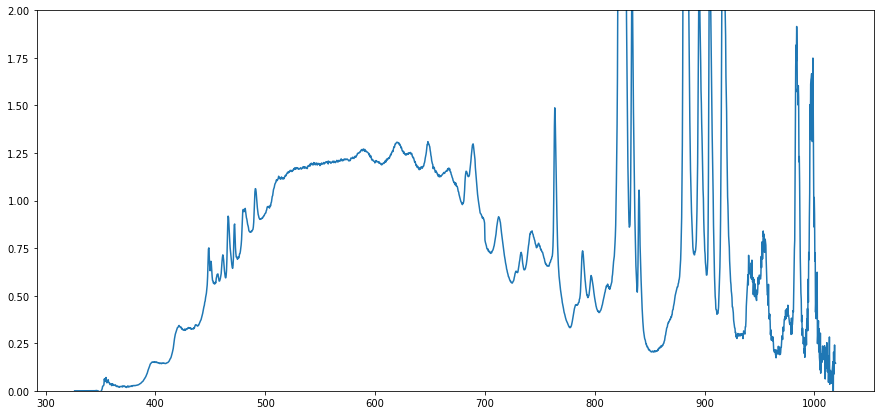

In [381]:
j = 99

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_data[:,0,j], spectra_data[:,1,j])
plt.ylim(0,2)
#ax.legend()


In [382]:
#Now we construct the spectra matrix (the closest spectras corresponding to the measurement cutting wavelengths)
spectra_matrix = None
spectra_matrix_wls = spectra_data[:,0,0]
for i in range(len(measure_divwl)):
    actual_cutwl = measure_divwl[i]
    spectra_data_actual_index = np.where(cut_wl_relation[:,2] == closest(cut_wl_relation[:,2], actual_cutwl))[0]
    actual_cut_wl_spectra = np.transpose(spectra_data[:,1,spectra_data_actual_index[0]])
    #print([actual_cut_wl, cut_wl_relation[actual_spectra_data_index_cutwl[0],2]])
    actual_spectra_matrix_cut_wl = cut_wl_relation[spectra_data_actual_index[0],2]
    if i == 0:
        spectra_matrix_cutwl = actual_spectra_matrix_cut_wl
        spectra_matrix_cutwl_ideal = actual_cutwl
        spectra_matrix = actual_cut_wl_spectra
    else:
        spectra_matrix_cutwl = np.vstack((spectra_matrix_cutwl, actual_spectra_matrix_cut_wl))
        spectra_matrix_cutwl_ideal = np.vstack((spectra_matrix_cutwl_ideal, actual_cutwl))
        spectra_matrix = np.vstack((spectra_matrix, actual_cut_wl_spectra))

In [413]:
#Now we construct the c matrix
c_matrix_min_wl = 400
c_matrix_max_wl = 800
c_matrix_res_wl = 10

#mintomax_wl_distrib = np.linspace(ideal_min-inc_cutwl/2, ideal_max+inc_cutwl/2, ideal_max-ideal_min+int(inc_cutwl)+1)#print(mintomax_wl_distrib)
c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)
c_matrix = np.zeros((len(measure_divwl),len(c_matrix_wl)))
#EQE_int_const = np.linspace(1, 0.8, len(c_matrix[:,0]))
for i in range(len(c_matrix[:,0])):
    actual_spectra_interpolation = interpolate.interp1d(spectra_matrix_wls, spectra_matrix[i,:], kind='cubic')
    iteration_wl = measure_divwl[i]    

    for j in range(len(c_matrix_wl)):
        actual_wl = c_matrix_wl[j]       
        actual_spectra_average = statistics.mean(actual_spectra_interpolation(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10 )))
        #actual_spectra_average = actual_spectra_interpolation(c_matrix_wl[j])
        c_matrix[i,j] = 0.01*c_matrix_res_wl*actual_spectra_average/1240*actual_wl#*EQE_int_const[i]
        # if abs(c_matrix[i,j])<= 0.002 or  c_matrix[i,j]<=0:
        #     c_matrix[i,j] = 0

print(c_matrix.shape)       
#c_matrix = np.flip(c_matrix, axis=1)

(41, 40)


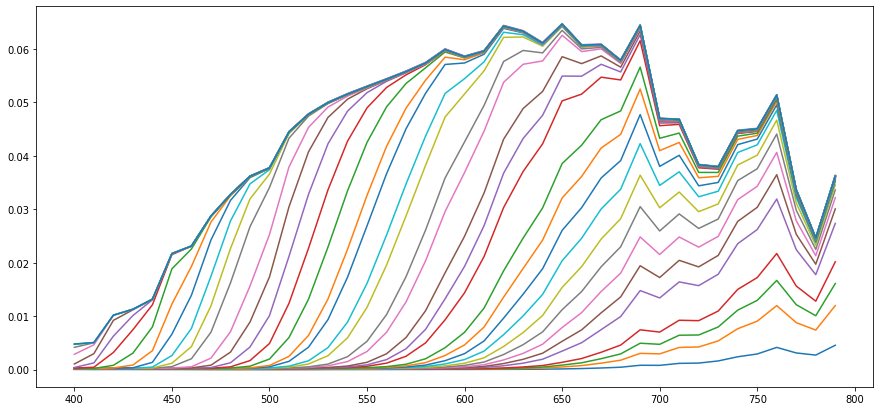

In [414]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(len(c_matrix[:,0])):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, c_matrix[j,:])#, label=str(j))#c_matrix_wl,
    #ax.legend()


In [386]:
#Now we will make the macro_c_matrix and macro_measure_jsc which are the interpolations in the vertical directions for having more information. 

equations_min = min(spectra_matrix_cutwl[:])[0]
equations_max = max(measure_divwl[:])
total_equations = 600
macro_c_matrix = np.zeros((total_equations, len(c_matrix[0,:])))

for j in range(len(macro_c_matrix[0,:])):
    actual_wl_interpolation = interpolate.interp1d(spectra_matrix_cutwl[0:-1,0], c_matrix[0:-1,j], kind='cubic')

    macro_c_matrix[:,j] = actual_wl_interpolation(np.linspace(equations_min, equations_max, total_equations))

macro_measure_Jsc_interpolation = interpolate.interp1d(measure_divwl, measure_Jsc, kind='cubic')
macro_measure_Jsc = macro_measure_Jsc_interpolation(np.linspace(equations_min, equations_max, total_equations))

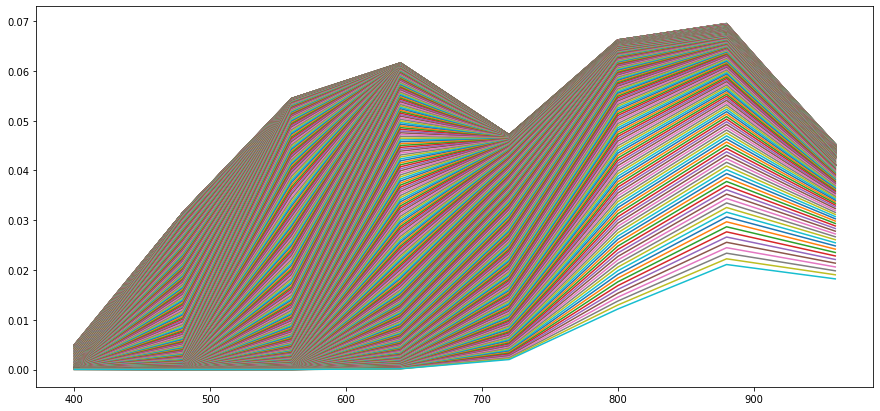

In [353]:
fig, ax = plt.subplots(figsize=(15,7))
for j in range(len(macro_c_matrix[:,0])):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, macro_c_matrix[j,:])#, label=str(j))#c_matrix_wl,
    #ax.legend()

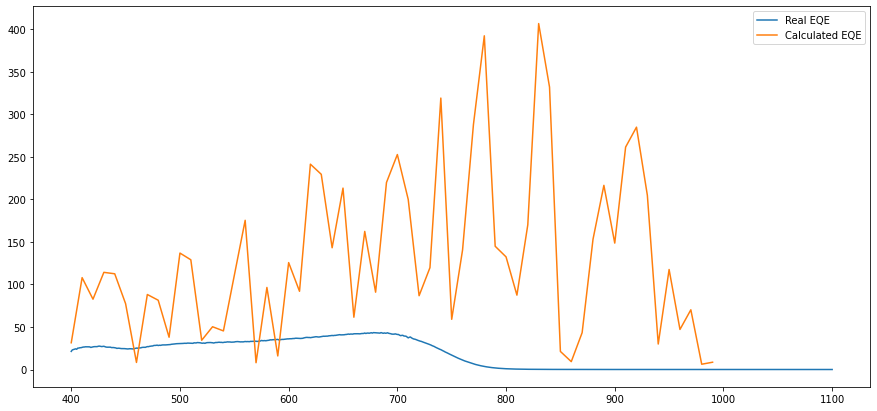

In [404]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(macro_c_matrix, 0.58*macro_measure_Jsc, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, abs(EQE_linearsolution), label = 'Calculated EQE')
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


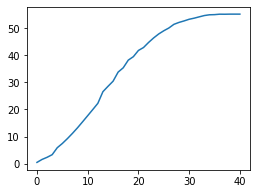

In [388]:
#Now we take a measured EQE and we calculate the theoretical Jsc corresponding to each row of the c_matrix

Jsc_correction_factor = 1
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)
EQE_interpolation = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='cubic')
Jsc_calculated = np.zeros(len(c_matrix[:,0]))

for j in range(len(c_matrix[:,0])):
    spectra_interpolation = interpolate.interp1d(spectra_data[:,0,j], spectra_data[:,1,j], kind='cubic')
    Jsc_summ = 0
    for i in range(len(c_matrix[0,:])):
        actual_wl = c_matrix_wl[i]
        Jsc_summ = Jsc_summ + Jsc_correction_factor*EQE_interpolation(actual_wl)*c_matrix[j,i]
    
    Jsc_calculated[j] = Jsc_summ #+ np.random.randint(-1, 1)/100

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(Jsc_calculated[:])

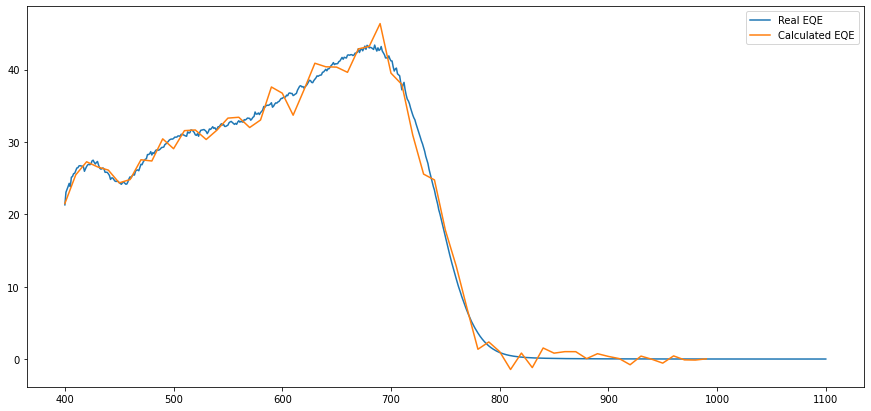

In [389]:

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, Jsc_calculated, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


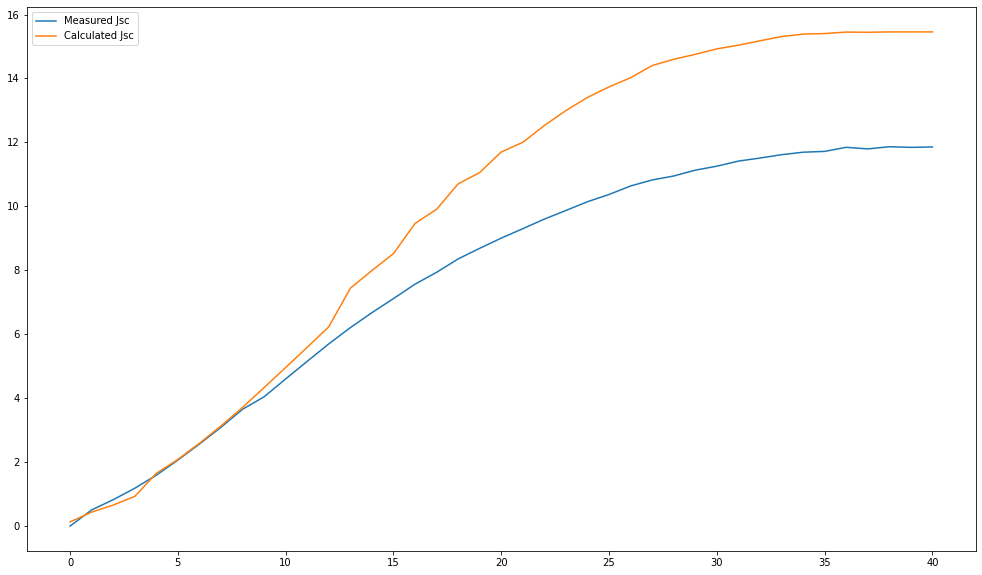

In [401]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(measure_Jsc[:], label= 'Measured Jsc')
ax.plot(0.28*Jsc_calculated[:], label='Calculated Jsc')
plt.legend()

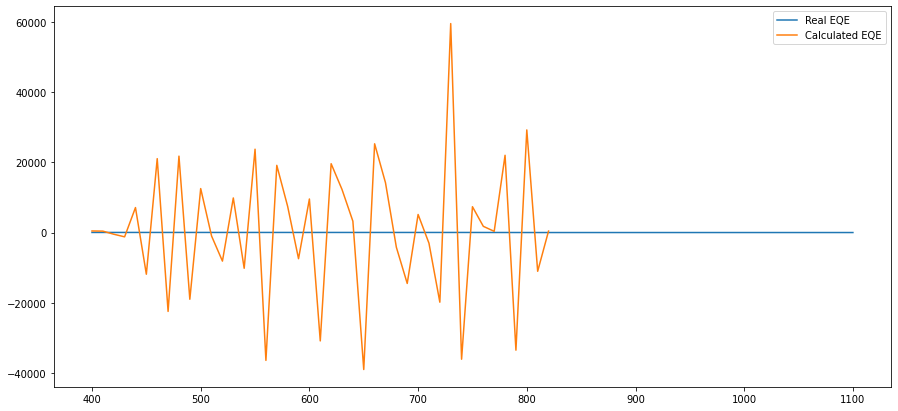

In [229]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, 0.58*measure_Jsc, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


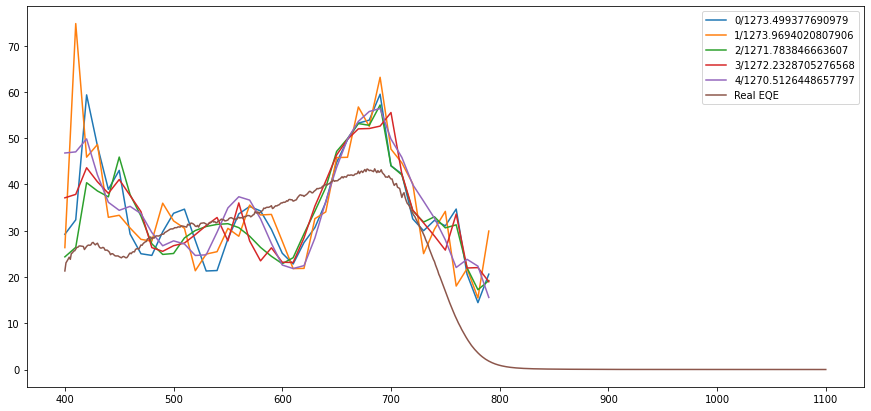

In [419]:
#Now we do the resolution of the measured EQE with the least squares minimum
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])
    EQE_diff_summ = np.sum(EQE_minimize[:])
    # if EQE_diff_summ <=10:
    #     print (EQE_diff_summ)

    return np.sum(EQE_diff_summ)

#c_matrix[:,45:] = 0

bnds = optimize.Bounds(0, 100)

fig, ax = plt.subplots(figsize=(15,7))
EQE_0 = np.zeros((len(c_matrix_wl)))
EQE_minimize_coef = np.zeros((5))
EQE_minimize_solution_all = np.zeros((len(c_matrix_wl),len(EQE_minimize_coef)))
for j in range(len(EQE_minimize_coef)):
    for i in range(len(EQE_0)):
        EQE_0[i] = 5*j

    minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix, 5*measure_Jsc),bounds=bnds, )   #0.55*measure_Jsc #Jsc_calculated
    #minimize_solution = optimize.least_squares(EQE_minimize, EQE_0[:], args = (macro_c_matrix, 0.6*macro_measure_Jsc),bounds=(0,100))             
    EQE_minimize_solution_all[:,j]= minimize_solution.x
    EQE_minimize_coef[j] = EQE_minimize(EQE_minimize_solution_all[:,j],c_matrix,measure_Jsc)
    ax.plot(c_matrix_wl, 1*EQE_minimize_solution_all[:,j], label = str(j)+'/'+str(EQE_minimize_coef[j]))


#print(EQE_approximation, EQE_aproximation[:,0])
#EQE_aproximation[:] = 30*EQE_aproximation[:]


real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

#EQE_approximation[-1,0] = 350
#ax.plot(c_matrix_wl, 300*EQE_minimize_solution, label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
#ax.plot(c_matrix_wl,50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)


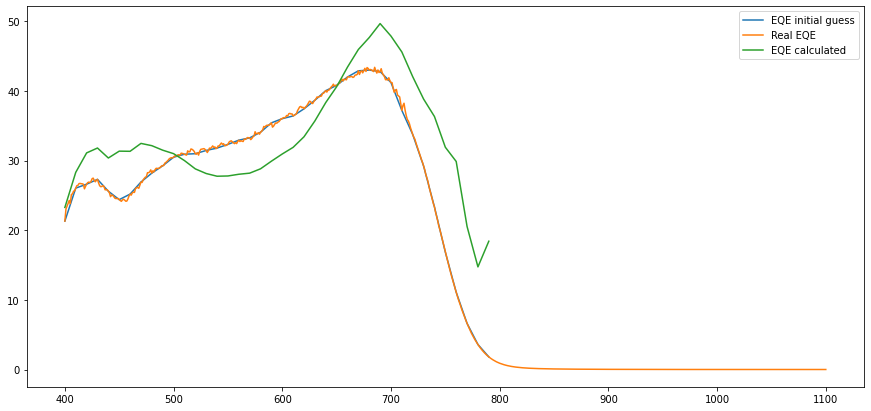

In [418]:
#now, trying the real EQE as initial guess:
fig, ax = plt.subplots(figsize=(15,7))

real_EQE_interpolation = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='cubic')
EQE_0 = 1*real_EQE_interpolation(c_matrix_wl)
ax.plot(c_matrix_wl, EQE_0, label='EQE initial guess')

bnds = optimize.Bounds(0, 100)
#minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix, 0.58*measure_Jsc),bounds=bnds, )   #0.58*measure_Jsc
minimize_solution = optimize.least_squares(EQE_minimize, EQE_0[:], args = (c_matrix, 5*measure_Jsc),bounds=(0,100))             
EQE_minimize_solution= minimize_solution.x
EQE_minimize_coef = EQE_minimize(EQE_minimize_solution,c_matrix,measure_Jsc)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, 1*EQE_minimize_solution,label='EQE calculated')
plt.legend()
